# A Simple Compiler for a Fragment of  `C`

This file shows how a simple compiler for a fragment of the programming language `C` can be implemented using `Ply`.

First, we describe the grammar of our language using EBNF-notation, since this enables us to give a very concise presentation of the grammar.
Below, the token 'NUMBER' stands for natural numbers and 'ID' represents identifiers.
```
program: function+
       
function: 'int' ID '(' ('int', ID (',' 'int' ID)*)?  ')' '{' decl* stmnt* '}' 
    
decl: 'int' ID ';'  
    
stmnt: '{' stmnt* '}'
     | ID '=' expr ';' 
     | 'if' '(' boolExpr ')' stmnt 
     | 'if' '(' boolExpr ')' stmnt 'else' stmnt 
     | 'while' '(' boolExpr ')' stmnt 
     | 'return' expr ';'
     | expr ';'             
     
boolExpr: expr ('==' | '!=' | '<=' | '>=' | '<' | '>')  expr 
        | '!' boolExpr             
        | boolExpr ('&&' | '||') boolExpr
        | '(' boolExpr ')'
     
expr: expr ('+' | '-' | '*' | '/' | '%') expr 
    | '(' expr ')' 
    | NUMBER
    | ID ('(' (expr (',' expr)*)? ')')?  
```
This grammar is ambiguous.  We will later resolve the ambiguity by specifying the appropriate operator precedences. 

## Specification of the Scanner

In [43]:
import ply.lex as lex

In [44]:
tokens = [ 'NUMBER', 'ID', 'EQ', 'NE', 'LE', 'GE', 'AND', 'OR',
           'INT', 'IF', 'ELSE', 'WHILE', 'RETURN'
         ]

The token `NUMBER` specifies a natural number.

In [45]:
t_NUMBER = r'0|[1-9][0-9]*'

Below, we define the tokens for operator symbols consisting of more than one character.

In [46]:
t_EQ  = r'=='
t_NE  = r'!='
t_LE  = r'<='
t_GE  = r'>='
t_AND = r'&&'
t_OR  = r'\|\|'

Our version of `C` allows both *single-line comments* and *multi-line comments*.
- The regular expression `/\*(.|\n)*?\*/` recognizes multi-line comments.
  Multi-line comments start with the string `/*` and end with the string `*/`.
  Note the use of the *non-greedy* quantor `*?`.  If we have code like
  ```
  /* blah */ a = 1; /* blub */
  ```
  the greedy quantor would recognize the whole line as one comment. 
- The regular expression `//.*` recognizes single-line comments.
  A single line comment starts with the string `//` and extends to the end of the line.

In [47]:
def t_COMMENT(t):
    r'(/\*(.|\n)*?\*/)|(//.*)'
    t.lexer.lineno += t.value.count('\n')
    pass

The keywords `'int', 'if', 'else', 'while', 'return'` have to be dealt with separately as they are syntactical identical to identifiers.  The dictionary `Keywords` shown below maps every keyword to its *token type*.

In [48]:
Keywords = { 'int'   : 'INT', 
             'if'    : 'IF',
             'else'  : 'ELSE', 
             'while' : 'WHILE', 
             'return': 'RETURN'
           }

When an identifier is read, we first have to check whether the identifier is one of our keywords.  If so, we assign the corresponding token type that is stored in the dictionary `Keywords`.  Otherwise, the token type is set to `ID`.

In [49]:
def t_ID(t):
    r'[a-zA-Z][a-zA-Z0-9_]*'
    t.type = Keywords.get(t.value, 'ID')
    return t

Operators consisting of a single character do not need an associated token type.

In [50]:
literals = ['+', '-', '*', '/', '%', '(', ')', '{', '}', ';', '=', '<', '>', '!', ',']

White space, i.e. *space characters*, *tabulators*, and *carriage returns* are ignored. 

In [51]:
t_ignore  = ' \t\r'

Syntactically, newline characters are ignored. However, we still need to keep track of them in order to know the current line number, which is used for error messages.

In [52]:
def t_newline(t):
    r'\n'
    t.lexer.lineno += 1
    return

Given a `token`, the function `find_colum` returns the column where `token` starts.  This is possible, because every token contains a reference to the current lexer as `token.lexer` and this lexer in turn stores the string that is given to it via the reference `lexer.lexdata`.  Furthermore, `token.lexpos` is the number of characters that precede `token`.

In [53]:
def find_column(token):
    program    = token.lexer.lexdata  # the complete string given to the scanner
    line_start = program.rfind('\n', 0, token.lexpos) 
    return token.lexpos - line_start

The function `t_error` is called for any token `t` that can not be scanned by the lexer.  In this case, `t.value[0]` is the first character that is not recognized by the scanner.  This character is discarded.  After that, scanning proceeeds as if nothing has happened.

In [54]:
def t_error(t):
    column = find_column(t)
    print(f"Illegal character '{t.value[0]}' in line {t.lineno}, column {column}.")
    t.lexer.skip(1)

The next assignment is necessary to pretend that the code given above is part of some file.

In [55]:
__file__ = 'main'

In [56]:
lexer = lex.lex()

In [57]:
def test_scanner(file_name):
    with open(file_name, 'r') as handle:
        program = handle.read() 
    print(program)
    lexer.input(program)
    lexer.lineno = 1          # reset line number
    return [t for t in lexer] # start scanning and collect all tokens

In [58]:
!cat Examples/MySum.c

int sum(int n) {
    int s;
    s = 0;
    while (n != 0) {
        s = s + n;
        n = n - 1;
    }
    return s;
}

int main() {
    int n;
    n = 6 * 6;
    println(sum(n));
}


In [59]:
for t in test_scanner('Examples/MySum.c'):
    print(t)

int sum(int n) {
    int s;
    s = 0;
    while (n != 0) {
        s = s + n;
        n = n - 1;
    }
    return s;
}

int main() {
    int n;
    n = 6 * 6;
    println(sum(n));
}

LexToken(INT,'int',1,0)
LexToken(ID,'sum',1,4)
LexToken((,'(',1,7)
LexToken(INT,'int',1,8)
LexToken(ID,'n',1,12)
LexToken(),')',1,13)
LexToken({,'{',1,15)
LexToken(INT,'int',2,21)
LexToken(ID,'s',2,25)
LexToken(;,';',2,26)
LexToken(ID,'s',3,32)
LexToken(=,'=',3,34)
LexToken(NUMBER,'0',3,36)
LexToken(;,';',3,37)
LexToken(WHILE,'while',4,43)
LexToken((,'(',4,49)
LexToken(ID,'n',4,50)
LexToken(NE,'!=',4,52)
LexToken(NUMBER,'0',4,55)
LexToken(),')',4,56)
LexToken({,'{',4,58)
LexToken(ID,'s',5,68)
LexToken(=,'=',5,70)
LexToken(ID,'s',5,72)
LexToken(+,'+',5,74)
LexToken(ID,'n',5,76)
LexToken(;,';',5,77)
LexToken(ID,'n',6,87)
LexToken(=,'=',6,89)
LexToken(ID,'n',6,91)
LexToken(-,'-',6,93)
LexToken(NUMBER,'1',6,95)
LexToken(;,';',6,96)
LexToken(},'}',7,102)
LexToken(RETURN,'return',8,108)
LexToken(ID,'s',8,115)
L

## Specification of the Parser

Since `Ply` does not support <span style="font-variant: small-caps;">Ebnf</span> we had to rewrite the grammar that was
given previously as follows:
```
program
    : function
    | function program

function 
    : INT ID '(' param_list ')' '{' decl_list stmnt_list '}'

param_list 
    : /* epsilon */
    | INT ID 
    | INT ID ',' ne_param_list

ne_param_list
    : INT ID
    | INT ID ',' ne_param_list
    
decl_list
    : /* epsilon */
    | INT ID ';' decl_list

stmnt_list
    : /* epsilon */
    | stmnt stmnt_list
    
stmnt 
    : IF '(' bool_expr ')' stmnt                 
    | IF '(' bool_expr ')' stmnt ELSE stmnt
    | WHILE '(' bool_expr ')' stmnt
    | '{' stmnt_list '}' 
    | ID '=' expr ';'  
    | RETURN expr ';'   
    | expr ';'       

bool_expr 
    : bool_expr '||' bool_expr
    | bool_expr '&&' bool_expr 
    | '!' bool_expr   
    | '(' bool_expr ')'
    | expr '==' expr     
    | expr '!=' expr     
    | expr '<=' expr     
    | expr '>=' expr     
    | expr '<'  expr      
    | expr '>'  expr     
 
expr: expr '+'  expr                 
    | expr '-' expr               
    | expr '*' expr               
    | expr '/' expr 
    | expr '%' expr 
    | '(' expr ')' 
    | NUMBER
    | ID                      
    | ID '(' expr_list ')'       

expr_list
    : /* epsilon */
    | expr
    | expr ',' ne_expr_list

ne_expr_list
    : expr
    | expr ',' ne_expr_list

```
We will use precedence declarations to resolve the ambiguity that is inherent in this grammar.

In [60]:
import ply.yacc as yacc

The *start variable* of our grammar is `program`.

In [61]:
start = 'program'

Below, the precedence declarations for the tokens `'IF'` and `'ELSE'` are needed to solve the [dangling else problem](https://en.wikipedia.org/wiki/Dangling_else). 
The point is that the precedence of the keyword `'ELSE'` has to be higher than the precedence of the keyword `'if'` so that a program of the form
```
if (a == 1) if (b == 1) x = 2; else x = 3;
```
is interpreted as
```
if (a == 1) {
    if (b == 1) {
        x = 2;
    } else {
        x = 3
    }
}
```
and not as 
```
if (a == 1) {
    if (a == 2) {
        x = 2;
    } 
} else {
    x = 3
}
```

In [62]:
precedence = (
    ('nonassoc', 'IF'),
    ('nonassoc', 'ELSE'),
    ('left', 'OR'),
    ('left', 'AND'),
    ('right', '!'),
    ('nonassoc', 'EQ', 'NE', 'LE', 'GE', '<', '>'),
    ('left', '+', '-'),
    ('left', '*', '/', '%')
)

In [63]:
def p_program_one(p):
    "program : function"
    p[0] = ('program', p[1])
    
def p_program_more(p):
    "program : function program"
    p[0] = ('program', p[1]) + p[2][1:]

In [64]:
def p_function(p):
    "function : INT ID '(' param_list ')' '{' decl_list stmnt_list '}'"
    p[0] = ('fct', p[2], p[4], p[7], p[8])

In [65]:
def p_param_list_empty(p):
    "param_list :"
    p[0] = ('.', )
    
def p_param_list_one(p):
    "param_list : INT ID"
    p[0] = ('.', p[2])
    
def p_param_list_more(p):
    "param_list : INT ID ',' ne_param_list"
    p[0] = ('.', p[2]) + p[4][1:]

def p_ne_param_list_one(p):
    "ne_param_list : INT ID"
    p[0] = ('.', p[2])
    
def p_ne_param_list_more(p):
    "ne_param_list : INT ID ',' ne_param_list"
    p[0] = ('.', p[2]) + p[4][1:]

In [66]:
def p_decl_list_one(p):
    "decl_list :"
    p[0] = ('.',)

def p_decl_list_more(p):
    "decl_list : INT ID ';' decl_list"
    p[0] = ('.', p[2]) + p[4][1:]

In [67]:
def p_stmnt_list_one(p):
    "stmnt_list :"
    p[0] = ('.',)

def p_stmnt_list_more(p):
    "stmnt_list : stmnt stmnt_list"
    p[0] = ('.', p[1]) + p[2][1:]

In the grammar rule
$$ \texttt{stmnt} \rightarrow \texttt{'if'}\;\texttt{'('}\; \texttt{bool\_expr}\; \texttt{')'}\; \texttt{stmnt}$$
the rightmost token is `')'`.  However, this token does not have a precedence.  Therefore, the grammar rule
does not have a precedence either.  Hence, we manually assign the precedence of the token `IF` to this rule via 
the keyword `%prec`.  This way, the shift/reduce conflict resulting from the *dangling-else ambiguity* can be resolved.

In [68]:
def p_stmnt_if(p):
    "stmnt : IF '(' bool_expr ')' stmnt %prec IF"
    p[0] = ('if', p[3], p[5])   
    
def p_stmnt_if_else(p):
    "stmnt : IF '(' bool_expr ')' stmnt ELSE stmnt"
    p[0] = ('if-else', p[3], p[5], p[7])
    
def p_stmnt_while(p):
    "stmnt : WHILE '(' bool_expr ')' stmnt"
    p[0] = ('while', p[3], p[5])
    
def p_stmnt_block(p):
    "stmnt : '{' stmnt_list '}'"
    p[0] = p[2]
    
def p_stmnt_assign(p):
    "stmnt : ID '=' expr ';'"
    p[0] = ('=', p[1], p[3])

def p_stmnt_return(p):
    "stmnt : RETURN expr ';'"
    p[0] = ('return', p[2])
    
def p_stmnt_expr(p):
    "stmnt : expr ';'"
    p[0] = p[1]

In [69]:
def p_bool_expr_or(p):
    "bool_expr : bool_expr OR bool_expr"
    p[0] = ('||', p[1], p[3])
    
def p_bool_expr_and(p):
    "bool_expr : bool_expr AND bool_expr"
    p[0] = ('&&', p[1], p[3])

def p_bool_expr_neg(p):
    "bool_expr : '!' bool_expr"
    p[0] = ('!', p[2])
    
def p_bool_expr_paren(p):
    "bool_expr : '(' bool_expr ')'"
    p[0] = p[2]
    
def p_bool_expr_eq(p):
    "bool_expr : expr EQ expr"
    p[0] = ('==', p[1], p[3])

def p_bool_expr_ne(p):
    "bool_expr : expr NE expr"
    p[0] = ('!=', p[1], p[3])

def p_bool_expr_le(p):
    "bool_expr : expr LE expr"
    p[0] = ('<=', p[1], p[3])
    
def p_bool_expr_ge(p):
    "bool_expr : expr GE expr"
    p[0] = ('>=', p[1], p[3])
    
def p_bool_expr_lt(p):
    "bool_expr : expr '<' expr"
    p[0] = ('<', p[1], p[3])

def p_bool_expr_gt(p):
    "bool_expr : expr '>' expr"
    p[0] = ('>', p[1], p[3])

In [70]:
def p_expr_plus(p):
    "expr : expr '+' expr"
    p[0] = ('+', p[1], p[3])
    
def p_expr_minus(p):
    "expr : expr '-' expr"
    p[0] = ('-', p[1], p[3])
    
def p_expr_times(p):
    "expr : expr '*' expr"
    p[0] = ('*', p[1], p[3])
    
def p_expr_divide(p):
    "expr : expr '/' expr"
    p[0] = ('/', p[1], p[3])
    
def p_expr_modulo(p):
    "expr : expr '%' expr"
    p[0] = ('%', p[1], p[3])
    
def p_expr_group(p):
    "expr : '(' expr ')'"
    p[0] = p[2]

def p_expr_number(p):
    "expr : NUMBER"
    p[0] = ('Number', p[1])

def p_expr_id(p):
    "expr : ID"
    p[0] = p[1]
    
def p_expr_fct_call(p):
    "expr : ID '(' expr_list ')'"
    p[0] = ('call', p[1]) + p[3][1:]

In [71]:
def p_expr_list_empty(p):
    "expr_list :"
    p[0] = ('.',)
    
def p_expr_list_one(p):
    "expr_list : expr"
    p[0] = ('.', p[1])     

def p_expr_list_more(p):
    "expr_list : expr ',' ne_expr_list"
    p[0] = ('.', p[1]) + p[3][1:]     

def p_ne_expr_list_one(p):
    "ne_expr_list : expr"
    p[0] = ('.', p[1]) 
    
def p_ne_expr_list_more(p):
    "ne_expr_list : expr ',' ne_expr_list"
    p[0] = ('.', p[1]) + p[3][1:] 

In [72]:
def p_error(t):
    column = find_column(t)
    if t:
        print(f'Syntax error at token "{t.value}" in line {t.lineno}, column {column}.')
    else:
        print('Syntax error at end of input.')

Setting the optional argument `write_tables` to `False` **is required** to prevent an obscure bug where the parser generator tries to read an empty parse table.  

In [73]:
parser = yacc.yacc(write_tables=False, debug=True);

Generating LALR tables


As we have used *precedence declarations* to resolve all shift/reduce conflicts, the action table contains no conflict.  
The shift-reduce conflict resulting from the *dangling else problem* manifests itself in state `84` and is resolved in favor 
of shifting.

In [74]:
!cat parser.out

Created by PLY version 3.11 (http://www.dabeaz.com/ply)

Grammar

Rule 0     S' -> program
Rule 1     bool_expr -> bool_expr OR bool_expr
Rule 2     decl_list -> <empty>
Rule 3     expr_list -> <empty>
Rule 4     expr -> expr + expr
Rule 5     function -> INT ID ( param_list ) { decl_list stmnt_list }
Rule 6     param_list -> <empty>
Rule 7     program -> function
Rule 8     stmnt -> IF ( bool_expr ) stmnt
Rule 9     stmnt_list -> <empty>
Rule 10    bool_expr -> bool_expr AND bool_expr
Rule 11    decl_list -> INT ID ; decl_list
Rule 12    expr_list -> expr
Rule 13    expr -> expr - expr
Rule 14    param_list -> INT ID
Rule 15    program -> function program
Rule 16    stmnt -> IF ( bool_expr ) stmnt ELSE stmnt
Rule 17    stmnt_list -> stmnt stmnt_list
Rule 18    bool_expr -> ! bool_expr
Rule 19    expr_list -> expr , ne_expr_list
Rule 20    expr -> expr * expr
Rule 21    param_list -> INT ID , ne_param_list
Rule 22    stmnt -> WHILE ( bool_expr ) stmnt
Rule 23    bool_expr -> ( bool_exp

The notebook `AST-2-Dot.ipynb` provides the function `tuple2dot`.  This function can be used to visualize the abstract syntax tree that is generated by the function `yacc.parse`.

In [75]:
%run ../Chapter-07/AST-2-Dot.ipynb

The function `parse` takes a `file_name` as ist sole argument.  The file is read and parsed. 
The resulting parse tree is visualized using `graphviz`.  It is important to reset the
attribute `lineno` of the scanner, for otherwise error messages will not display the correct line numbers.

In [76]:
def parse(file_name):
    lexer.lineno = 1
    with open(file_name, 'r') as handle:
        program = handle.read() 
    ast = yacc.parse(program)
    print(ast)
    return tuple2dot(ast)

In [77]:
!cat -n Examples/MySum.c

     1	int sum(int n) {
     2	    int s;
     3	    s = 0;
     4	    while (n != 0) {
     5	        s = s + n;
     6	        n = n - 1;
     7	    }
     8	    return s;
     9	}
    10	
    11	int main() {
    12	    int n;
    13	    n = 6 * 6;
    14	    println(sum(n));
    15	}


('program', ('fct', 'sum', ('.', 'n'), ('.', 's'), ('.', ('=', 's', ('Number', '0')), ('while', ('!=', 'n', ('Number', '0')), ('.', ('=', 's', ('+', 's', 'n')), ('=', 'n', ('-', 'n', ('Number', '1'))))), ('return', 's'))), ('fct', 'main', ('.',), ('.', 'n'), ('.', ('=', 'n', ('*', ('Number', '6'), ('Number', '6'))), ('call', 'println', ('call', 'sum', 'n')))))


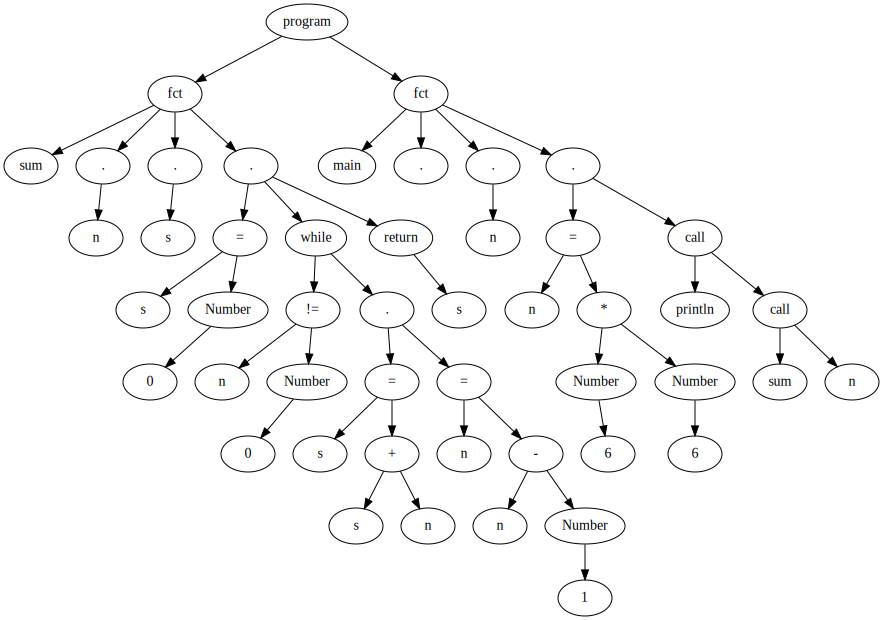

In [78]:
parse('Examples/MySum.c')

The function `indent` is used to indent the generated assembler commands by preceding them with 8 space characters. 

In [79]:
def indent(s):
    return ' ' * 8 + s

The method `compile_expr(expr, st, class_name)` takes three arguments:
- `expr` is an *abstract syntax tree* that represents an expression.  
  This abstract syntax tree is in turn represented as a nested tuple.  
- `st` is short for *symbol table*.  This is a dictionary that maps variable
  names to natural numbers.  Given a variable `x`, the number `st[x]` specifies
  the location where the variable `x` is stored on the stack with respect to the 
  local stack frame.
- `class_name` is the name of the class that is to be generated.

The function returns a pair of the form `(cmds, size)`.
- `cmds` is a list of assembler commands,
- `size` is the maximum size of the stack that is needed. 

In [80]:
def compile_expr(expr, st, class_name):
    match expr:
        case var if isinstance(var, str): # expr is a variable name
            Cmd = indent(f'iload {st[var]}')
            return [Cmd], 1
        case 'Number', n:
            Cmd = indent(f'ldc {n}')
            return [Cmd], 1
        case ('+' | '-' | '*' | '/' | '%') as op, lhs, rhs:
            L1, sz1 = compile_expr(lhs, st, class_name)
            L2, sz2 = compile_expr(rhs, st, class_name)
            OpToCmd = { '+': 'iadd', '-': 'isub', '*': 'imul', '/': 'idiv', '%': 'irem' }
            Cmd     = indent(OpToCmd[op])
            return L1 + L2 + [Cmd], max(sz1, 1 + sz2)
        case 'call', 'println', *args:
            CmdLst    = [indent('getstatic java/lang/System/out Ljava/io/PrintStream;')]
            stck_size = 0
            cnt       = 0
            for arg in args:
                L, sz_arg = compile_expr(arg, st, class_name)
                stck_size = max(stck_size, cnt + 1 + sz_arg)
                CmdLst   += L
                cnt      += 1
            CmdLst += [indent(f'invokevirtual java/io/PrintStream/println({"I"*cnt})V')]
            return CmdLst, stck_size
        case 'call', f, *args:
            CmdLst    = []
            stck_size = 0
            cnt       = 0
            for arg in args:
                L, sz_arg = compile_expr(arg, st, class_name)
                stck_size = max(stck_size, cnt + sz_arg)
                CmdLst   += L
                cnt      += 1
            CmdLst += [indent(f'invokestatic {class_name}/{f}({"I"*cnt})I')]
            return CmdLst, max(stck_size, 1)
        case _:
            assert False, f'Error in compile_expr({expr}, {st}, {class_name})'

The following is a test of the function `compile_expr`.

In [81]:
expr = ('call', 'sum', ('+', 'x', 'y'))
st   = { 'x': 0, 'y': 1 }
compile_expr(expr, st, 'Sum')

(['        iload 0',
  '        iload 1',
  '        iadd',
  '        invokestatic Sum/sum(I)I'],
 2)

The variable `label_counter` is a global counter that is used to create unique label names.
Every call of `new_label` creates a new, unique label.

In [ ]:
label_counter = 0

def new_label():
    global label_counter
    label_counter += 1
    return 'l' + str(label_counter)

The method `compile_bool(expr, st, class_name)` takes three arguments:
- `expr` is an *abstract syntax tree* that represents a Boolean expression.  
  This abstract syntax tree is in turn represented as a nested tuple.  
- `st` is short for *symbol table*.  This is a dictionary that maps variable
  names to natural numbers.  Given a variable `x`, the number `st[x]` specifies
  the location where the variable `x` is stored on the stack with respect to the 
  local stack frame.
- `class_name` is the name of the class that is to be generated.

The function returns a pair of the form `(cmds, size)`.
- `cmds` is a list of assembler commands,
- `size` is the maximum size of the stack that is needed. 

In [ ]:
def compile_bool(expr, st, class_name):
    match expr:
        case ('==' | '!=' | '<=' | '>=' | '<' | '>') as op, lhs, rhs:
            OpToCmd = { '==': 'if_icmpeq', 
                        '!=': 'if_icmpne', 
                        '<=': 'if_icmple',
                        '>=': 'if_icmpge',
                        '<' : 'if_icmplt',
                        '>' : 'if_icmpgt'
                      }
            L1, sz1    = compile_expr(lhs, st, class_name)
            L2, sz2    = compile_expr(rhs, st, class_name)
            true_label = new_label()
            next_label = new_label()
            CmdLst     = L1 + L2
            cmd        = OpToCmd[op]
            CmdLst    += [indent(cmd + ' ' + true_label)]
            CmdLst    += [indent('bipush 0')]
            CmdLst    += [indent('goto ' + next_label)]
            CmdLst    += [' ' * 4 + true_label + ':']
            CmdLst    += [indent('bipush 1')]
            CmdLst    += [' ' * 4 + next_label + ':']
            return CmdLst, max(sz1, 1 + sz2)
        case ('&&' | '||') as op, lhs, rhs:
            OpToCmd      = { '&&': 'iand', '||': 'ior' }
            L1, sz1      = compile_bool(lhs, st, class_name)
            L2, sz2      = compile_bool(rhs, st, class_name)
            cmd          = OpToCmd[op]
            CmdLst       = L1 + L2 + [indent(cmd)]
            return CmdLst, max(sz1, 1 + sz2)
        case '!', arg:
            L, sz  = compile_expr(arg, st, class_name)
            CmdLst = [indent('bipush 1')] + L + [indent('isub')]
            return CmdLst, sz + 1
        case _:
            assert False, f'Error in compile_bool({expr}, {st}, {class_name})'

Below is a test for the function `compile_bool`.

In [ ]:
expr = ('==', 'x', ('Number', '0'))
st   = { 'x': 0, 'y': 1}
compile_bool(expr, st, 'Sum')

The method `compile_stmnt(stmnt, st, class_name)` takes three arguments:
- `stmnt` is an *abstract syntax tree* that represents a statement.  
  This abstract syntax tree is in turn represented as a nested tuple.  
- `st` is short for *symbol table*.  This is a dictionary that maps variable
  names to natural numbers.  Given a variable `x`, the number `st[x]` specifies
  the location where the variable `x` is stored on the stack with respect to the 
  local stack frame.
- `class_name` is the name of the class that is to be generated.

The function returns a pair of the form `(cmds, size)`.
- `cmds` is a list of assembler commands,
- `size` is the maximum size of the stack that is needed. 

In [ ]:
def compile_stmnt(stmnt, st, class_name):
    match stmnt:
        case '=', var, expr:
            CmdLst, sz = compile_expr(expr, st, class_name)
            CmdLst    += [indent(f'istore {st[var]}')]
            return CmdLst, sz
        case 'if', expr, sub_stmnt:
            L1, sz1    = compile_bool(expr, st, class_name)
            L2, sz2    = compile_stmnt(sub_stmnt, st, class_name)
            else_label = new_label()
            lbl_stmnt  = ' ' * 4 + else_label + ':'
            CmdLst = L1 + [indent(f'ifeq {else_label}')] + L2 + [lbl_stmnt]
            return CmdLst, max(sz1, sz2)
        case 'if-else', expr, then_stmnt, else_stmnt:
            L1, sz1    = compile_bool(expr, st, class_name)
            L2, sz2    = compile_stmnt(then_stmnt, st, class_name)
            L3, sz3    = compile_stmnt(else_stmnt, st, class_name)        
            else_label = new_label()
            next_label = new_label()
            if_stmnt   = indent(f'ifeq {else_label}')
            else_stmnt = ' ' * 4 + else_label + ':'
            next_stmnt = ' ' * 4 + next_label + ':'
            goto_stmnt = indent(f'goto {next_label}')
            CmdLst = L1 + [if_stmnt] + L2 + [goto_stmnt, else_stmnt] + L3 + [next_stmnt]
            return CmdLst, max(sz1, sz2, sz3)
        case 'while', expr, body_stmnt:
            L1, sz1    = compile_bool(expr, st, class_name)
            L2, sz2    = compile_stmnt(body_stmnt, st, class_name)
            loop_label = new_label()
            next_label = new_label()
            if_stmnt   = indent(f'ifeq {next_label}')
            loop_stmnt = ' ' * 4 + loop_label + ':'        
            next_stmnt = ' ' * 4 + next_label + ':'
            goto_stmnt = indent(f'goto {loop_label}')
            CmdLst = [loop_stmnt] + L1 + [if_stmnt] + L2 + [goto_stmnt, next_stmnt]
            return CmdLst, max(sz1, sz2)
        case 'return', expr:
            CmdLst, sz = compile_expr(expr, st, class_name)
            CmdLst    += [indent('ireturn')]
            return CmdLst, sz
        case '.', *stmnt_lst:
            CmdLst = []
            size   = 0
            for s in stmnt_lst:
                L, sz = compile_stmnt(s, st, class_name)
                CmdLst += L
                size   = max(size, sz)
            return CmdLst, size
        case _: # it must be an expression statement
            return compile_expr(stmnt, st, class_name)

In [ ]:
stmnt = ('if', ('==', 'x', 'y'), ('=', 'x', ('Number', '42')))
compile_stmnt(stmnt, st, 'Sum')

In [ ]:
stmnt = ('if-else', ('<', 'x', 'y'), ('=', 'x', 'y'), ('=', 'y', 'x'))
compile_stmnt(stmnt, st, 'Sum')

In [ ]:
stmnt = ('while', ('<', 'x', 'y'), ('=', 'x', ('+', 'x', ('Number', '1'))))
compile_stmnt(stmnt, st, 'Sum')

In [ ]:
stmnt = ('.', ('=', 'x', 'y'), ('.', ('=', 'x', ('Number', '1')), ('=', 'y', 'x')))
compile_stmnt(stmnt, st, 'Sum')

In [ ]:
def compile_fct(fct_def, class_name):
    global label_counter
    label_counter = 0
    _, name, parameters, variables, stmnts = fct_def
    _, *parameters = parameters
    _, *variables  = variables
    _, *stmnts     = stmnts
    m   = len(parameters)
    n   = len(variables)
    st  = {}
    cnt = 0
    for var in parameters + variables:
        st[var] = cnt
        cnt    += 1
    CmdLst = []
    size   = 0
    for stmnt in stmnts:
        L, sz = compile_stmnt(stmnt, st, class_name)
        CmdLst += L
        size = max(size, sz)
    limit_locals = f'.limit locals {m+n}'
    limit_stack  = f'.limit stack  {size}'
    return_stmnt = indent('return')
    if name != 'main':
        method = f'.method public static {name}({"I"*m})I'
        CmdLst = [method, limit_locals, limit_stack] + CmdLst + ['.end method']
        return CmdLst, size
    else:
        method = '.method public static main([Ljava/lang/String;)V'
        CmdLst = [method, limit_locals, limit_stack] + CmdLst + [return_stmnt, '.end method']
        return CmdLst, size

In [ ]:
f = ('fct', 'sum', ('.', 'x'), ('.', 'y', 'z'), ('.', ('return', 'x')))
compile_fct(f, 'Sum')

In [ ]:
import os

In [ ]:
file = "~/Drive/Kurse/Formal-Languages/Python/Chapter-12/Examples/Primes.c"
print(os.path.dirname(file))
print(os.path.basename(file))
print(os.path.join('abc', 'xyz.c'))

The input to `compile_program(file_name)` is the name of a `C` file.  This file assumed to have the ending `.c`.
This file is compiled and the resulting assembler file is written into a file with the same name but the ending `.jas`.

In [ ]:
def compile_program(file_name):
    directory = os.path.dirname(file_name)
    base      = os.path.basename(file_name)
    base      = base[:-2]
    outfile   = os.path.join(directory, base + '.jas')
    with open(file_name, 'r') as handle:
        program = handle.read()
    lexer.lineno = 1
    ast = yacc.parse(program)
    _, *fct_lst = ast
    CmdLst = []
    for fct in fct_lst:
        L, _ = compile_fct(fct, base)
        CmdLst += L + ['\n']
    with open(outfile, 'w') as handle:
        handle.write('.class public ' + base + '\n');
        handle.write('.super java/lang/Object\n\n');
        handle.write('.method public <init>()V\n');
        handle.write('    aload 0\n');
        handle.write('    invokenonvirtual java/lang/Object/<init>()V\n');
        handle.write('    return\n');
        handle.write('.end method\n\n');
        for cmd in CmdLst:
            handle.write(cmd + '\n')

The file `Primes.c` is a simple `C` program that computes the prime numbers in a naive way.

In [ ]:
%cd Examples

In [ ]:
ls -l

In [ ]:
!cat Primes.c

In [ ]:
compile_program('Primes.c')

In [ ]:
!ls -l 

In [ ]:
!cat Primes.jas

Next, we generate Java byte code using
[jasmin](http://jasmin.sourceforge.net).

In [ ]:
!jasmin Primes.jas

Finally, we run the generated byte code.

In [ ]:
!ls -l

In [ ]:
!java Primes